<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/10_Duolingo_q1lpipe4_MLsplitting_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='cornflowerblue' size=4>Introduction</font>

Featureset4 for addressing Q1 (what makes a word easy or difficult to remember)with word vectors has been preprocessed.

The training set contains around 8 million records with 16% records with forgotten words. Since the dataset is imbalanced, and the dataset is large enough, downsampling will be done.

Plan:

1. Split datasets into training and validation with 80-20. 
2. Downsample training set to equal class proportions.

Classical ML models: understanding overall feature importances.
Prep: from the downsampled training set, select at most 1 million records, and fit the following models

1. Logistic Regression (L2 penalty, vary C and class weight)
2. Decision Tree (vary max_depth, class_weight)


Ensemble techniques:
Prep: Use the full downsampled dataset
1. Random Forest (vary n_estimators, )
2. XGBoost
3. AdaBoost

Neural Net (keras)
1. Dense architecture
2


## <font color = 'cornflowerblue' size=4>Splitting trainingset into train and validation sets</font>

Importing libraries, mounting google drive, and getting Q1TRAIN pipe1 set. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
q1trainXsp = decompress_pickle(path_name+"Q1TRAIN_pipe4.pbz2") 

In [3]:
q1trainXsp.shape, q1trainXsp.size/10**6

((8070561, 28), 225.975708)

In [4]:
q1trainXsp = q1trainXsp.drop('lexeme_id',axis=1)

In [5]:
q1train_y = decompress_pickle(path_name+"Q1TRAIN_Y_pipe4.pbz2") 

In [6]:
type(q1trainXsp), type(q1train_y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [7]:
from scipy.sparse import coo_matrix

## Splitting into training and validation sets 90-10

splitting into 80-20 training and validation set with a random state = 5. (had to remove stratify argument, because it doesn't work for sparse arrays)

In [8]:
from sklearn.model_selection import train_test_split

Xq1_train, Xq1_valid, yq1_train, yq1_valid = train_test_split(q1trainXsp,q1train_y,test_size=0.1,random_state=5)

In [9]:
Xq1_train.shape, Xq1_valid.shape, yq1_train.shape, yq1_valid.shape

((7263504, 27), (807057, 27), (7263504,), (807057,))

Fraction of ones in the train and validation sets

In [10]:
yq1_train.sum()/yq1_train.shape[0], yq1_valid.sum()/yq1_valid.shape[0]

(0.16344962431355445, 0.1641990590503521)

## <font color = 'cornflowerblue' size=4>Classical models:

The training set is now downsampled and reduced to 1 milion records for a quick run of classical models to see what the most important features are. 

### <font color = 'cornflowerblue' size=3>Downsampling training dataset</font>

In [11]:
# creating sparse dataframe from sparse matrix
df = pd.DataFrame(Xq1_train)
# combining with y
df['y'] = yq1_train

# nsplitting sparse dataframe by class values
df0 = df[df['y']==0]
df1 = df[df['y']==1]

# number of positive samples
numdf1 = df1.shape[0]

# what fraction of df0 do we need to equal the numbers of df1?
fractiondf0 = numdf1/df0.shape[0]

# sampling from negative class samples to get only the fraction needed 
df0_ = df0.sample(frac = fractiondf0,random_state = 15)

# recombine and shuffle downsampled negative samples df0_ and all of positive samples df1:
df_downsampled = pd.concat([df0_, df1],axis=0).sample(frac=1,random_state=20)



In [12]:
# create the sparse matrices ready for training
yq1_train_ds = df_downsampled['y']
Xq1_train_ds = df_downsampled.drop('y',axis=1)



In [13]:
Xq1_train_ds.shape, yq1_train_ds.shape, numdf1, df0_.shape, df1.shape, df0.shape, df.shape

((2374434, 27),
 (2374434,),
 1187217,
 (1187217, 28),
 (1187217, 28),
 (6076287, 28),
 (7263504, 28))

In [14]:
yq1_train_ds.sum()/yq1_train_ds.shape[0]

0.5

Since there are around 1.33 million records in the downsampled dataset, no more reduction is necessary. The number of positive and negative samples is equal. 

### <font color= 'cornflowerblue' size=3>Scaling downsampled dataset</font>

They are about the same, we will use this split to test a number of models. They are saved below:

First, we scale and transform the data using the min-max scaler. 

In [15]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MaxAbsScaler()

mm_scaler.fit(Xq1_train_ds[[col for col in Xq1_train_ds if col!='lexeme_id']])
Xq1_mm_train_ds = mm_scaler.transform(Xq1_train_ds)
Xq1_mm_valid_ds = mm_scaler.transform(Xq1_valid) # downsampled scaler is applied. 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [16]:
Xq1_mm_train_ds.shape

(2374434, 27)

###<font color = 'cornflowerblue' size= 3>Logistic regression</font>

Hyperparamters:
1. C
2. class weights


In [17]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate # return scores for many metrics

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV # to search hyperparameters in a grid 

classweight_vals = [{0:0.9,1:0.1},{0:0.01,1:0.99}]
C_vals = [10**(-3),1,10**3]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['C'] = C_vals


# iterate over 
logreg = LogisticRegression(solver = 'lbfgs',max_iter=50)
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg, n_jobs = 4, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=1,refit=False)

gridsearch_obj.fit(Xq1_mm_train_ds,yq1_train_ds)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=50), n_jobs=4,
             param_grid={'C': [0.001, 1, 1000],
                         'class_weight': [{0: 0.9, 1: 0.1},
                                          {0: 0.01, 1: 0.99}]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=1)

In [21]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_C','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

KeyError: ignored

Changing C had no real impact on the accuracy, which is still at the baseline value. Recall is either 1 or 0, indicating that the models either predict all 1s or all 0s.

Logistic regression does not seem promising to train on the full dataset, nor is it likely at 0.5 accuracy to give any information of feature importance. 

Decision trees are tried next. 

### <font color='cornflowerblue' size=3>Decision Trees</font>

The downsampled dataset is trained on decision trees with varying class weight and max_depth.

In [19]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

#classweight_vals = [{0:0.45,1:0.55},{0:0.55,1:0.45}]
maxdepth_vals = [5,30]

para_dict =dict()
#para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq1_mm_train_ds,yq1_train_ds)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END max_depth=5; accuracy: (test=0.575) average_precision: (test=0.599) f1: (test=0.540) recall: (test=0.498) roc_auc: (test=0.607) total time=  12.9s
[CV 2/3] END max_depth=5; accuracy: (test=0.576) average_precision: (test=0.598) f1: (test=0.541) recall: (test=0.499) roc_auc: (test=0.608) total time=  12.6s
[CV 3/3] END max_depth=5; accuracy: (test=0.576) average_precision: (test=0.599) f1: (test=0.536) recall: (test=0.490) roc_auc: (test=0.607) total time=  12.7s
[CV 1/3] END max_depth=30; accuracy: (test=0.556) average_precision: (test=0.534) f1: (test=0.557) recall: (test=0.559) roc_auc: (test=0.554) total time=  36.8s
[CV 2/3] END max_depth=30; accuracy: (test=0.556) average_precision: (test=0.536) f1: (test=0.554) recall: (test=0.552) roc_auc: (test=0.555) total time=  38.3s
[CV 3/3] END max_depth=30; accuracy: (test=0.555) average_precision: (test=0.534) f1: (test=0.554) recall: (test=0.553) roc_auc: (test=0.55

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 30]}, refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=3)

In [22]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,5,11.27,1.46,0.58,0.60,0.61,0.54,0.50
1,30,35.44,2.44,0.56,0.53,0.55,0.56,0.55


In [25]:
dtree = DecisionTreeClassifier(max_features=10)


maxdepth_vals = [6,10,15]

para_dict =dict()

para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq1_mm_train_ds,yq1_train_ds)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END max_depth=6; accuracy: (test=0.573) average_precision: (test=0.594) f1: (test=0.550) recall: (test=0.522) roc_auc: (test=0.605) total time=   6.7s
[CV 2/3] END max_depth=6; accuracy: (test=0.578) average_precision: (test=0.601) f1: (test=0.575) recall: (test=0.570) roc_auc: (test=0.609) total time=   6.8s
[CV 3/3] END max_depth=6; accuracy: (test=0.571) average_precision: (test=0.589) f1: (test=0.513) recall: (test=0.452) roc_auc: (test=0.601) total time=   6.5s
[CV 1/3] END max_depth=10; accuracy: (test=0.585) average_precision: (test=0.612) f1: (test=0.583) recall: (test=0.582) roc_auc: (test=0.620) total time=   9.3s
[CV 2/3] END max_depth=10; accuracy: (test=0.586) average_precision: (test=0.615) f1: (test=0.590) recall: (test=0.596) roc_auc: (test=0.623) total time=   9.1s
[CV 3/3] END max_depth=10; accuracy: (test=0.585) average_precision: (test=0.614) f1: (test=0.591) recall: (test=0.600) roc_auc: (test=0.62

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(max_features=10),
             param_grid={'max_depth': [6, 10, 15]}, refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=3)

In [26]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,6,5.17,1.50,0.57,0.59,0.61,0.55,0.51
1,10,7.78,1.59,0.59,0.61,0.62,0.59,0.59
2,15,9.63,1.76,0.59,0.61,0.63,0.59,0.60


The test precision is around 0.6. 

Epxloring max_depth in more detail:

Using max depth = 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 6


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 7


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 8


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 11


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 12


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 13


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


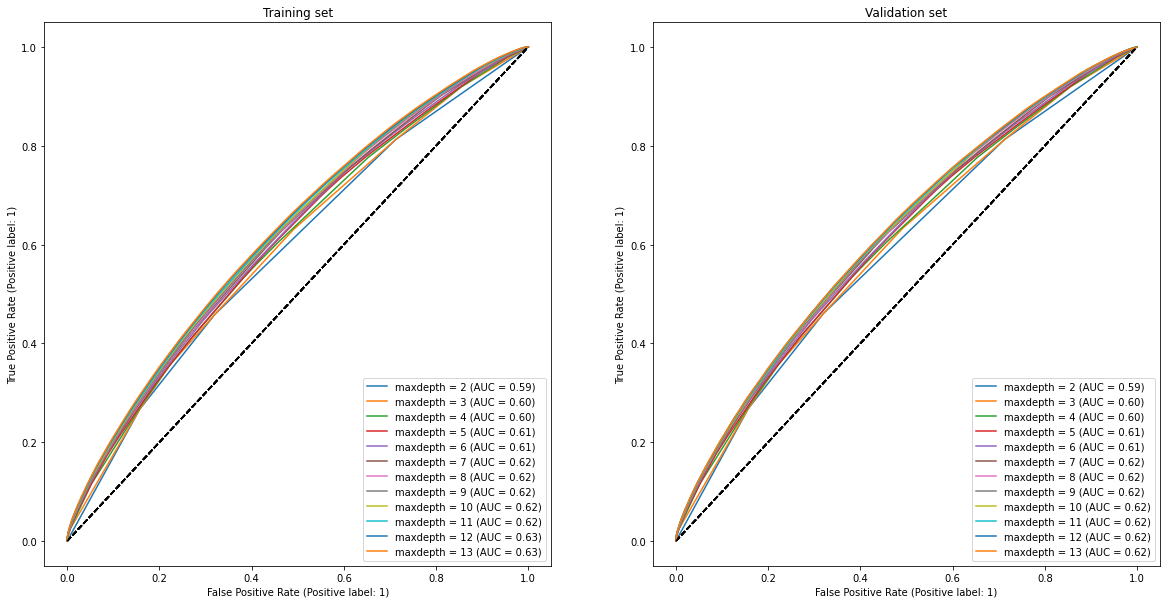

In [30]:
from sklearn.metrics import accuracy_score,\
 roc_auc_score, plot_roc_curve,f1_score,\
  confusion_matrix, classification_report,\
  precision_recall_curve


# creating dictionaries to store metrics for different knn models
valid_acc = dict()
train_acc = dict()

valid_AUC = dict()
train_AUC = dict()

train_cm = dict()
valid_cm = dict()

train_f1 = dict()
valid_f1 = dict()

train_prc = dict()
valid_prc = dict()

train_proba1 = dict()
valid_proba1 = dict()


# create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))



depths = range(2,14)

for d in depths:
  print(f"Using max depth = {d}")
  DTCmodel = DecisionTreeClassifier(max_depth = d,class_weight={0:.01,1:0.99}) # intitalize a Decision tree classifier model with a new max depth
  DTCmodel.fit(Xq1_mm_train_ds,yq1_train_ds)

  # predicting on training and validation sets
  y_train_predicted = DTCmodel.predict(Xq1_mm_train_ds) 
  y_valid_predicted = DTCmodel.predict(Xq1_mm_valid_ds) 

  # soft predictions on training and validation data
  y_train_proba = DTCmodel.predict_proba(Xq1_mm_train_ds) 
  y_valid_proba = DTCmodel.predict_proba(Xq1_mm_valid_ds)

  # saving metrics for training and validayion data
  # calculate accuracy
  valid_acc[d] = accuracy_score(yq1_train_ds, y_train_predicted)
  train_acc[d] = accuracy_score(yq1_valid,y_valid_predicted)

  # getting roc_auc scores for training and validation sets 
  valid_AUC[d] = roc_auc_score(yq1_valid, y_valid_proba[:,1])
  train_AUC[d] = roc_auc_score(yq1_train_ds, y_train_proba[:,1])

  # getting confusion matrices
  valid_cm[d] = confusion_matrix(yq1_valid, y_valid_predicted)
  train_cm[d] = confusion_matrix(yq1_train_ds, y_train_predicted)

  # F1 -scores
  valid_f1[d] = f1_score(yq1_valid, y_valid_predicted)
  train_f1[d] = f1_score(yq1_train_ds, y_train_predicted)

  # precision recall curves
  valid_prc[d] = precision_recall_curve(yq1_valid, y_valid_proba[:,1])
  train_prc[d] = precision_recall_curve(yq1_train_ds, y_train_proba[:,1])

  # saving probabilities of positive class
  valid_proba1[d] = y_valid_proba[:,1]
  train_proba1[d] = y_train_proba[:,1]
  

  # plot ROC curve for training and validation sets
  plot_roc_curve(DTCmodel, Xq1_mm_train_ds, yq1_train_ds, ax=axes[0],name=f"maxdepth = {d}")
  plot_roc_curve(DTCmodel, Xq1_mm_valid_ds, yq1_valid, ax=axes[1],name=f"maxdepth = {d}")

  # Add line y=x and titls
  for axis_num, plot_title in enumerate(['Training set', 'Validation set']):
    axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
    axes[axis_num].set_title(plot_title)

plt.show()


In [31]:
dtree_metrics = pd.DataFrame()
dtree_metrics['valid_accuracy'] = pd.Series(valid_acc)
dtree_metrics['train_accuracy'] = pd.Series(train_acc)
dtree_metrics['valid_AUC'] = pd.Series(valid_AUC)
dtree_metrics['train_AUC'] = pd.Series(train_AUC)
dtree_metrics['valid_f1'] = pd.Series(valid_f1)
dtree_metrics['train_f1'] = pd.Series(train_f1)
dtree_metrics = dtree_metrics.reset_index()
dtree_metrics['Max_depth'] = dtree_metrics['index']
dtree_metrics = dtree_metrics.drop('index',axis=1)
display(np.around(dtree_metrics,2))

,valid_accuracy,train_accuracy,valid_AUC,train_AUC,valid_f1,train_f1,Max_depth
0,0.5,0.16,0.59,0.59,0.28,0.67,2
1,0.5,0.16,0.60,0.60,0.28,0.67,3
2,0.5,0.16,0.60,0.60,0.28,0.67,4
3,0.5,0.16,0.61,0.61,0.28,0.67,5
4,0.5,0.16,0.61,0.61,0.28,0.67,6
5,0.5,0.16,0.62,0.62,0.28,0.67,7
6,0.5,0.16,0.62,0.62,0.28,0.67,8
7,0.5,0.16,0.62,0.62,0.28,0.67,9
8,0.5,0.16,0.62,0.62,0.28,0.67,10
9,0.5,0.17,0.62,0.62,0.28,0.67,11


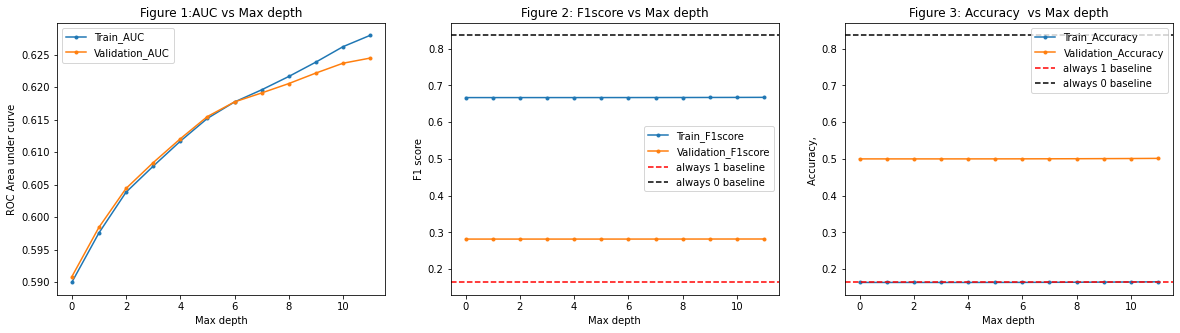

In [33]:
y_valid = yq1_valid
y_train = yq1_train

plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(dtree_metrics['train_AUC'],'.-',label='Train_AUC')
plt.plot(dtree_metrics['valid_AUC'],'.-',label='Validation_AUC')
plt.title("Figure 1:AUC vs Max depth")
plt.xlabel("Max depth")
plt.ylabel("ROC Area under curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(dtree_metrics['train_f1'],'.-',label='Train_F1score')
plt.plot(dtree_metrics['valid_f1'],'.-',label='Validation_F1score')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_f1 = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_f1 = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_f1,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_f1,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("F1 score")
plt.title("Figure 2: F1score vs Max depth")
plt.legend()

plt.subplot(1,3,3)
plt.plot(dtree_metrics['train_accuracy'],'.-',label='Train_Accuracy')
plt.plot(dtree_metrics['valid_accuracy'],'.-',label='Validation_Accuracy')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_acc = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_acc = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_acc,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_acc,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("Accuracy, ")
plt.title("Figure 3: Accuracy  vs Max depth")
plt.legend()

plt.show()

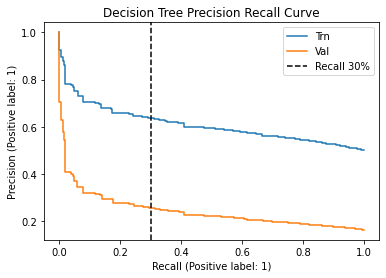

In [39]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

precision3, recall3, thresholds3 = precision_recall_curve(y_valid,valid_proba1[2])
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq1_train_ds,train_proba1[8])
plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(yq1_train_ds,train_proba1[8], ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(y_valid,valid_proba1[8], ax=ax,label="Val")

plt.title("Decision Tree Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,fp = precision3_t,xp = recall3_t)
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall-Val 30% = 20%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall-Trn 30% = 20%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')
plt.legend()
plt.show()

Makes sense that lower history correct gives a greater chance of forgetting the word. 

## <font color = 'cornflowerblue' size=4>Ensemble models</font>

## <font color = 'cornflowerblue' size=3>Random Forest</font>

### <font color = 'cornflowerblue' size = 3>XGBoost</font>

In [42]:
from xgboost import XGBClassifier


XGB_model = XGBClassifier(num_feature = 60,subsample = 0.3)
XGB_model.fit(Xq1_mm_train_ds, yq1_train_ds)
print(f"XG Boost train set score: {XGB_model.score(Xq1_mm_train_ds, yq1_train_ds)}")
print(f"XG Boost test set score: {XGB_model.score(Xq1_mm_valid_ds, yq1_valid)}")

XG Boost train set score: 0.5939524956263261
XG Boost test set score: 0.6086050923292903


In [44]:
yq1_train_preds_probs_xgb = XGB_model.predict_proba(Xq1_mm_train_ds)[:,1]
yq1_valid_preds_probs_xgb = XGB_model.predict_proba(Xq1_mm_valid_ds)[:,1]


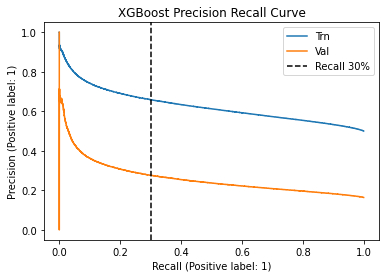

In [50]:
# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq1_valid, yq1_valid_preds_probs_xgb)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq1_train_ds, yq1_train_preds_probs_xgb)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq1_train_ds,yq1_train_preds_probs_xgb, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_probs_xgb, ax=ax,label="Val")

plt.title("XGBoost Precision Recall Curve")

# interpolating to find precision at recall = 30%
precision_at_recall3 = np.interp(x= 0.3,xp = precision3,fp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall2*100,2)}%")

plt.legend()
plt.show()

## AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier(n_estimators=100, learning_rate=1)

AB_model.fit(Xq1_mm_train_ds,yq1_train_ds)
y_probaAB = AB_model.predict_proba(Xq1_mm_valid_ds)[:,1]

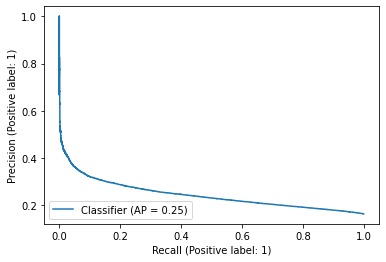

In [54]:
yq1_train_preds_probs_AB = AB_model.predict_proba(Xq1_mm_train_ds)[:,1]
yq1_valid_preds_probs_AB = AB_model.predict_proba(Xq1_mm_valid_ds)[:,1]


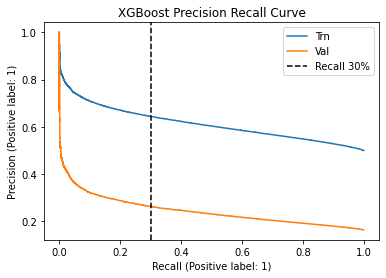

In [55]:
# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq1_valid, yq1_valid_preds_probs_AB)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq1_train_ds, yq1_train_preds_probs_AB)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq1_train_ds,yq1_train_preds_probs_AB, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_probs_AB, ax=ax,label="Val")

plt.title("XGBoost Precision Recall Curve")

# interpolating to find precision at recall = 30%
precision_at_recall3 = np.interp(x= 0.3,xp = precision3,fp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall2*100,2)}%")

plt.legend()
plt.show()

In [56]:
compressed_pickle(path_name+"AB_modeln150_lr1",AB_model)

## <font color = 'cornflowerblue' size = 4>Neural Nets</font>

The runtime is restarted with GPU to run with CUDA.

Since random_state is set during splitting, redoing it should give the same train and validation sets.

Downsampling and scaling will have to be repeated. 

Both the downsampled and non-downsampled train sets will be tried.

### <font color = 'cornflowerblue' size=3>Scaling non-downsampled train set</font>

In [58]:
Xq1_train = Xq1_train.drop('y',axis=1)

In [66]:
Xq1_train.shape

(7263504, 27)

In [59]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler1 = MaxAbsScaler()

mm_scaler1.fit(Xq1_train_ds)
Xq1_mm_train = mm_scaler1.transform(Xq1_train)
Xq1_mm_valid = mm_scaler1.transform(Xq1_valid) # 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [60]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [61]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [62]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [63]:
from tensorflow import keras
from tensorflow.keras import layers

Converting Xq1_mm_train, and Xq1_mm_valid to sparse tensorflow tensor

In [65]:
yq1_train_np = np.array(yq1_train)
yq1_valid_np = np.array(yq1_valid)

In [67]:
# Create a new sequential model
model = tf.keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(27, activation="relu",kernel_regularizer=regularizer))
model.add(layers.Dense(16, activation="relu",kernel_regularizer=regularizer))
model.add(layers.Dense(4, activation="relu",kernel_regularizer=regularizer))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [68]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
     
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.3)]
)

In [69]:
history = model.fit(np.array(Xq1_mm_train), yq1_train_np, epochs=30, verbose=1, batch_size=40000,validation_data = (Xq1_mm_valid,yq1_valid_np))

Epoch 1/30
182/182 [==============================] - 6s 8ms/step - loss: 0.5475 - precision_at_recall: 0.1738 - val_loss: 0.4649 - val_precision_at_recall: 0.2400
Epoch 2/30
182/182 [==============================] - 1s 6ms/step - loss: 0.4573 - precision_at_recall: 0.2428 - val_loss: 0.4538 - val_precision_at_recall: 0.2465
Epoch 3/30
182/182 [==============================] - 1s 6ms/step - loss: 0.4505 - precision_at_recall: 0.2459 - val_loss: 0.4498 - val_precision_at_recall: 0.2488
Epoch 4/30
182/182 [==============================] - 1s 6ms/step - loss: 0.4477 - precision_at_recall: 0.2456 - val_loss: 0.4479 - val_precision_at_recall: 0.2500
Epoch 5/30
182/182 [==============================] - 1s 6ms/step - loss: 0.4461 - precision_at_recall: 0.2448 - val_loss: 0.4466 - val_precision_at_recall: 0.2489
Epoch 6/30
182/182 [==============================] - 1s 6ms/step - loss: 0.4450 - precision_at_recall: 0.2419 - val_loss: 0.4455 - val_precision_at_recall: 0.2510
Epoch 7/30
182/1

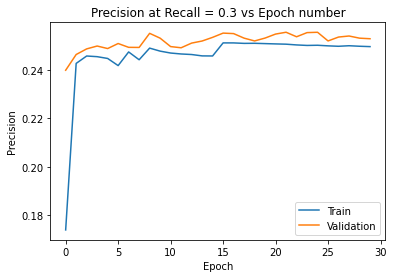

In [70]:
plt.plot(history.history['precision_at_recall'])
plt.plot(history.history['val_precision_at_recall'])
plt.title('Precision at Recall = 0.3 vs Epoch number')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

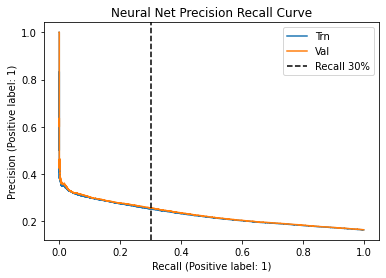

In [72]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
yq1_valid_preds_probs_nn = model.predict(Xq1_mm_valid)
yq1_train_preds_probs_nn = model.predict(Xq1_mm_train)

# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq1_valid, yq1_valid_preds_probs_nn)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq1_train, yq1_train_preds_probs_nn)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq1_train,yq1_train_preds_probs_nn, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_probs_nn, ax=ax,label="Val")

plt.title("Neural Net Precision Recall Curve")

# interpolating to find precision at recall = 30%
#precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
#precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall3*100,2)}%")

plt.legend()
plt.show()

In [73]:
import joblib
joblib.dump(model,path_name+"Q1_FS4_nn1")

INFO:tensorflow:Assets written to: ram://8da3bef5-d7fb-4a5e-b04b-b9eb66c66051/assets


['/content/drive/MyDrive/Q1_FS4_nn1']

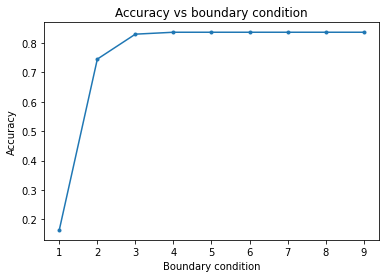

In [75]:
acc = dict()
for i in range(1,10):
  bc = i*.1
  acc[i] = accuracy_score(yq1_valid_np,np.where(yq1_valid_preds_probs_nn>=bc,1,0))

acc = pd.Series(acc)
plt.figure()
plt.xlabel("Boundary condition")
plt.ylabel("Accuracy")
plt.title("Accuracy vs boundary condition")
plt.plot(acc.index,acc,'.-')
plt.show()


Trying neural net with down-sampled dataset.

In [76]:
yq1_train_np_ds = np.array(yq1_train_ds)
yq1_valid_np_ds = np.array(yq1_valid)

The same architecture will be used:

In [77]:
history_ds = model.fit(Xq1_mm_train_ds, yq1_train_np_ds, epochs=15, verbose=1, batch_size=30000,validation_data = (Xq1_mm_valid_ds,yq1_valid_np_ds))

Epoch 1/25
80/80 [==============================] - 1s 8ms/step - loss: 0.6979 - precision_at_recall: 0.5736 - val_loss: 0.6743 - val_precision_at_recall: 0.2479
Epoch 2/25
80/80 [==============================] - 0s 6ms/step - loss: 0.6822 - precision_at_recall: 0.6228 - val_loss: 0.6759 - val_precision_at_recall: 0.2479
Epoch 3/25
80/80 [==============================] - 0s 6ms/step - loss: 0.6815 - precision_at_recall: 0.6260 - val_loss: 0.6742 - val_precision_at_recall: 0.2478
Epoch 4/25
80/80 [==============================] - 0s 6ms/step - loss: 0.6809 - precision_at_recall: 0.6244 - val_loss: 0.6807 - val_precision_at_recall: 0.2511
Epoch 5/25
80/80 [==============================] - 0s 6ms/step - loss: 0.6805 - precision_at_recall: 0.6287 - val_loss: 0.6832 - val_precision_at_recall: 0.2513
Epoch 6/25
80/80 [==============================] - 0s 6ms/step - loss: 0.6802 - precision_at_recall: 0.6316 - val_loss: 0.6815 - val_precision_at_recall: 0.2517
Epoch 7/25
80/80 [==========

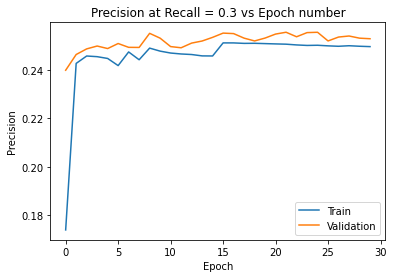

In [79]:
plt.plot(history.history['precision_at_recall'])
plt.plot(history.history['val_precision_at_recall'])
plt.title('Precision at Recall = 0.3 vs Epoch number')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

From comparing with the non-downsampled dataset, the downsampled-dataset does not seem to offer an advantage in validation performance. 

Trying with drop out to reduce overfitting further:

In [80]:
# Create a new sequential model
model3 = keras.Sequential()
# Create a regularizer with a factor of 0.005 and apply it to all hidden layers
regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model3.add(layers.Dense(27, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dropout(0.2)) # Set 20% of the nodes to 0. 
model3.add(layers.Dense(16, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dropout(0.2)) # Set 20% of the nodes to 0. 
model3.add(layers.Dense(8, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dense(4, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
model3.add(layers.Dense(1, activation="sigmoid"))

In [81]:
model3.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.3)]
)

In [82]:
history_reg_dropout = model3.fit(np.array(Xq1_mm_train), yq1_train_np, epochs=10, verbose=1, batch_size=40000,validation_data = (Xq1_mm_valid,yq1_valid_np))

Epoch 1/10
182/182 [==============================] - 2s 8ms/step - loss: 0.7012 - precision_at_recall_1: 0.1634 - val_loss: 0.6551 - val_precision_at_recall_1: 0.1642
Epoch 2/10
182/182 [==============================] - 1s 6ms/step - loss: 0.6242 - precision_at_recall_1: 0.1636 - val_loss: 0.5977 - val_precision_at_recall_1: 0.1642
Epoch 3/10
182/182 [==============================] - 1s 6ms/step - loss: 0.5770 - precision_at_recall_1: 0.1637 - val_loss: 0.5589 - val_precision_at_recall_1: 0.1642
Epoch 4/10
182/182 [==============================] - 1s 6ms/step - loss: 0.5435 - precision_at_recall_1: 0.1635 - val_loss: 0.5300 - val_precision_at_recall_1: 0.1642
Epoch 5/10
182/182 [==============================] - 1s 6ms/step - loss: 0.5181 - precision_at_recall_1: 0.1634 - val_loss: 0.5081 - val_precision_at_recall_1: 0.1642
Epoch 6/10
182/182 [==============================] - 1s 6ms/step - loss: 0.4988 - precision_at_recall_1: 0.1635 - val_loss: 0.4913 - val_precision_at_recall_1:

It appears that this model is underfitting. 

In [85]:
history_reg_dropout.history.keys()

dict_keys(['loss', 'precision_at_recall_1', 'val_loss', 'val_precision_at_recall_1'])

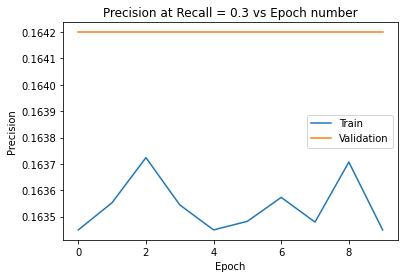

In [86]:
plt.plot(history_reg_dropout.history['precision_at_recall_1'])
plt.plot(history_reg_dropout.history['val_precision_at_recall_1'])
plt.title('Precision at Recall = 0.3 vs Epoch number')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Drop out did not add to the optimization (underfitting)

## Q1 TEST

In [90]:
q1testXsp = decompress_pickle(path_name+"Q1TEST_pipe4.pbz2") 

In [91]:
q1testXsp.shape, q1testXsp.size/10**6

((1795528, 28), 50.274784)

In [92]:
q1testXsp = q1testXsp.drop('lexeme_id',axis=1)

In [93]:
q1test_y = decompress_pickle(path_name+"Q1TEST_Y_pipe4.pbz2") 

In [94]:
type(q1testXsp), type(q1test_y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [95]:
# scaling with mmscaler 
q1testXsp

,delta,history_seen,history_frac,simoverdiff,EnglishIDF,sf_length,L_dist_sf_noaccents_norm,0,1,2,...,10,11,12,13,14,15,16,17,18,19
23,444649,3,1.000000,0.000159,0.002856,1,0.000000,-1.479051,-0.112675,0.246321,...,0.042690,-0.000190,0.012070,-0.009148,-0.025869,0.006845,-0.032530,-0.027243,0.018896,-0.009582
26,678813,3,1.000000,0.000159,0.222868,7,1.000000,-1.425464,-0.863519,-0.095533,...,0.005911,-0.087069,0.075160,-0.206693,0.139943,-0.012878,-0.040306,0.018671,-0.030123,-0.011078
30,8562343,3,1.000000,0.000159,1.106943,6,0.666667,-1.505185,0.034833,-0.259207,...,0.013261,-0.009184,0.015942,0.047982,0.000466,-0.050659,0.068211,0.022031,0.022755,-0.027425
41,6645723,5,1.000000,0.000159,0.048971,2,0.000000,-1.517464,-0.227870,0.089043,...,-0.026833,0.050615,-0.007909,0.016218,-0.015621,0.012019,-0.001548,-0.014283,-0.003592,-0.016742
50,7239420,3,0.666667,0.000159,3.385734,5,0.200000,-1.502134,1.108158,-0.151994,...,-0.042713,-0.110415,-0.093129,-0.106432,0.120222,-0.036931,0.027935,0.040192,0.031517,-0.057896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854159,441159,1,1.000000,0.000581,0.087485,4,1.000000,-1.511092,0.100793,-0.249287,...,-0.024546,0.013743,-0.017307,0.022002,0.008855,0.037489,-0.042158,-0.010851,-0.035558,0.003547
12854165,441159,1,1.000000,0.000581,0.064179,6,0.666667,-1.517300,0.050340,-0.133527,...,-0.009789,0.031197,0.051799,-0.058076,0.014629,0.008831,0.021586,0.022997,-0.074883,0.004688
12854166,441856,1,1.000000,0.000581,0.222868,6,0.666667,-1.488297,-0.392285,0.178377,...,-0.003565,0.004633,-0.067377,0.000899,0.009327,-0.025501,-0.075739,-0.010130,-0.022092,0.023490
12854203,177098,5,0.800000,0.000159,1.179408,10,0.200000,-1.543006,0.861492,0.137432,...,-0.019974,-0.054636,-0.101043,-0.060037,0.039488,0.001159,-0.045820,-0.001295,-0.095326,-0.068766


In [96]:
model_test = joblib.load(path_name+"Q1_FS4_nn1")

scale the test set

In [97]:
q1testX_mm = mm_scaler1.transform(q1testXsp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [98]:
q1test_y_preds = model_test.predict(q1testX_mm)
q1train_y_preds = model_test.predict(Xq1_mm_train)


In [100]:
q1valid_y_preds = model_test.predict(Xq1_mm_valid)

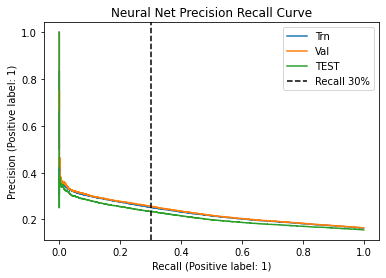

In [102]:


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq1_train_np,q1train_y_preds, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq1_valid_np,q1valid_y_preds, ax=ax,label="Val")
PrecisionRecallDisplay.from_predictions(q1test_y,q1test_y_preds, ax=ax,label="TEST")
#PrecisionRecallDisplay.from_predictions(yq3test_entode,yq3_test_entode_preds_probs_nn, ax=ax,label="En to De")

plt.title("Neural Net Precision Recall Curve")

# interpolating to find precision at recall = 30%
#precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
#precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall3*100,2)}%")

plt.legend()
plt.show()

At recall of 30%, there is just about 21% on the Test set. Performance matches well with the training and validation set. 